Some images are extremely similar but have completely different masks (one has mask the other not)

See https://www.kaggle.com/c/ultrasound-nerve-segmentation/forums/t/21495/is-the-training-data-accurate

This scripts tries to find such images

In [2]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

In [3]:
TRAIN_PATH = '../data/train'

In [44]:
def load_and_preprocess(imgname):
    img_fname = imgname
    mask_fname = os.path.splitext(imgname)[0] + "_mask.tif"
    img = cv2.imread(os.path.join(TRAIN_PATH, img_fname), cv2.IMREAD_GRAYSCALE)
    assert img is not None
    mask = cv2.imread(os.path.join(TRAIN_PATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    assert mask is not None
    
    #newsize = (img.shape[1] / 4, img.shape[0] / 4)
    #newsize = (128, 128)
    #img = cv2.resize(img, newsize)
    #mask = cv2.resize(mask, newsize)
    mask = (mask > 128).astype(np.float32)
    
    # TODO: Could subtract mean as on fimg above
    img = img.astype(np.float32) / 255.0
    np.ascontiguousarray(img)
    return img, mask


def load_patient(pid):
    fnames = [os.path.basename(fname) for fname in glob.glob(TRAIN_PATH + "/%d_*.tif" % pid) if 'mask' not in fname]
    imgs, masks = zip(*map(load_and_preprocess, fnames))
    return imgs, masks, fnames

In [47]:
imgs, masks, fnames = load_patient(6)

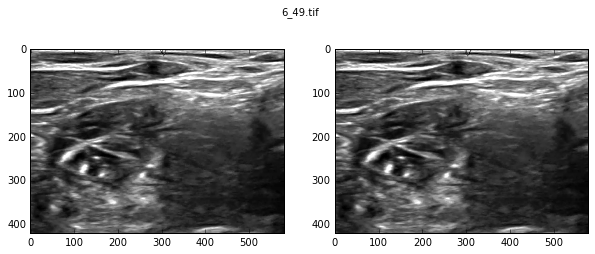

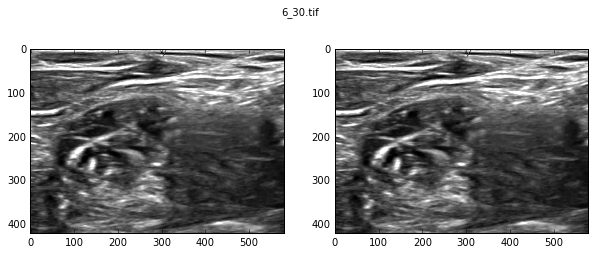

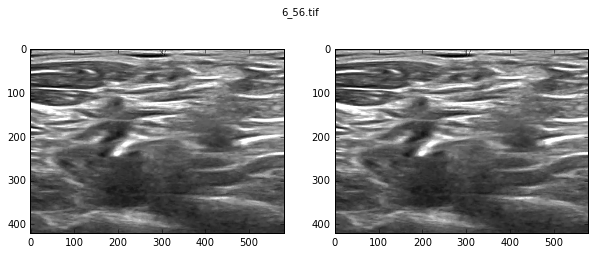

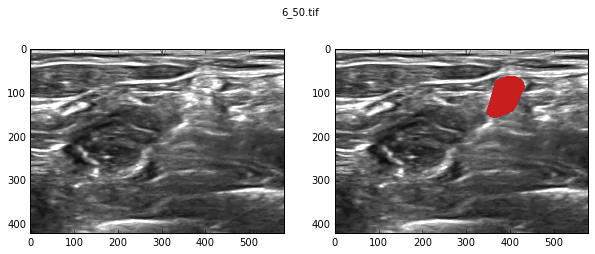

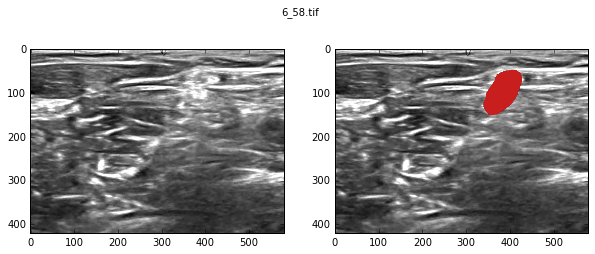

In [48]:
def show(i):
    pl.figure(figsize=(10, 4))
    pl.suptitle(fnames[i])
    pl.subplot(121)
    pl.imshow(imgs[i], cmap=cm.gray)
    
    pl.subplot(122)
    pl.imshow(imgs[i], cmap=cm.gray)
    h, w = imgs[i].shape[:2]
    overlay = np.zeros((h, w, 4), dtype=np.uint8)
    overlay[masks[i] > 0, :] = (200, 30, 30, 255)
    pl.imshow(overlay, alpha=1)
    
for i in range(5):
    show(i)

# Finding similar images with different masks

In [49]:
import skimage.util

def compute_img_hist(img):
    # Divide the image in blocks and compute per-block histogram
    blocks = skimage.util.view_as_blocks(img, block_shape=(20, 20))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 10))[0] for block in blocks]
    return np.concatenate(img_hists)

img = imgs[0]
compute_img_hist(img)

array([ 218,  720, 1472, 1577, 1566, 2338, 1737,  836, 1136,  466, 1216,
       1916, 1713, 1446, 1872, 1566,  734,  671,  565, 1118, 2110, 1548,
       1209, 1216, 1302,  775, 1757,  355,  562, 2152, 2214, 1713, 1411,
        958,  625, 1610,   25,  704, 2279, 3061, 2418, 1263,  751,  408,
        691,   20,  205, 2051, 3055, 2386, 1918,  930,  453,  582,   31,
        882, 3547, 2519, 2547, 1322,  450,  164,  138,  364, 2069, 3928,
       3358, 1204,  243,  166,   69,  199, 1169, 2410, 5552, 1835,  421,
         80,   51,   47,   35, 1619, 3075, 4864, 1478,  402,  118,   21,
          6,   17, 1552, 4690, 3175,  799,  539,  511,  219,   67,   48,
       1827, 5509, 1866,  925,  591,  552,  190,   73,   67, 2840, 5041,
       1432,  899,  695,  319,  138,   87,  149, 2209, 5337, 2075, 1108,
        391,  149,   85,   64,  182, 2574, 4963, 2177,  907,  357,  265,
        161,   71,  125, 2419, 4762, 2059, 1187,  716,  395,   62,    0,
          0, 2716, 3770, 1613, 1607, 1104,  672,  1

In [50]:
#hists = np.array([np.histogram(img, bins=np.linspace(0, 1, 20))[0] for img in imgs])
hists = np.array(map(compute_img_hist, imgs))
hists.shape

(120, 189)

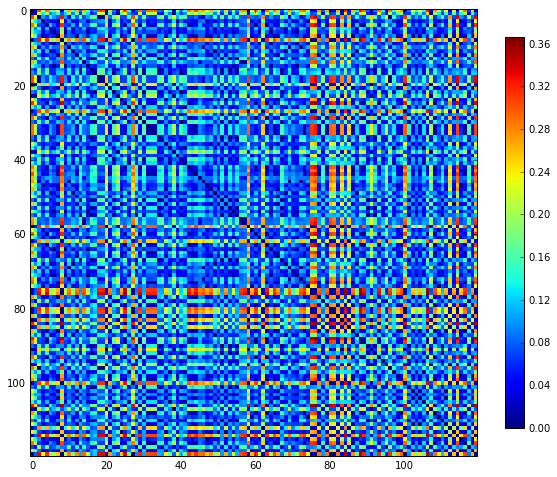

In [51]:
import scipy.spatial.distance as spdist

D = spdist.squareform(spdist.pdist(hists, metric='cosine'))

pl.figure(figsize=(10, 10))
pl.imshow(D, interpolation='nearest')
pl.colorbar(shrink=0.7)

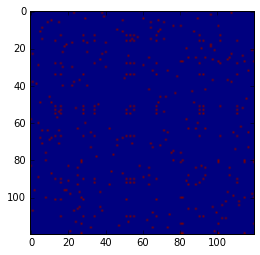

In [78]:
close_pairs = D + np.eye(D.shape[0]) < 0.008
pl.imshow(close_pairs)

In [79]:
close_ij = np.transpose(np.nonzero(close_pairs))
print close_ij.shape

(346, 2)


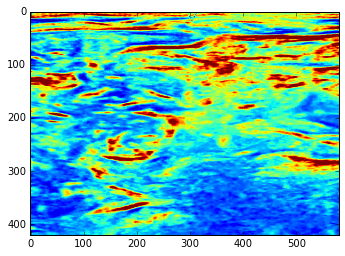

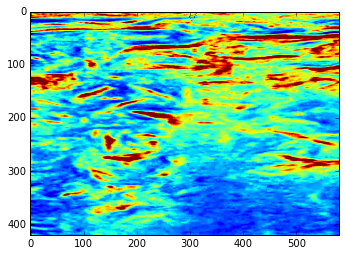

In [80]:
farthest = np.argmax(D[close_pairs])

pl.imshow(imgs[close_ij[farthest, 0]])
pl.figure()
pl.imshow(imgs[close_ij[farthest, 1]])

In [81]:
incoherent_ij = [(i, j) for i, j in close_ij if utils.dice_coefficient(masks[i], masks[j]) < 0.2]
incoherent_ij = np.array(incoherent_ij)
print incoherent_ij.shape

(72, 2)


0.0
D :  0.00768311233707


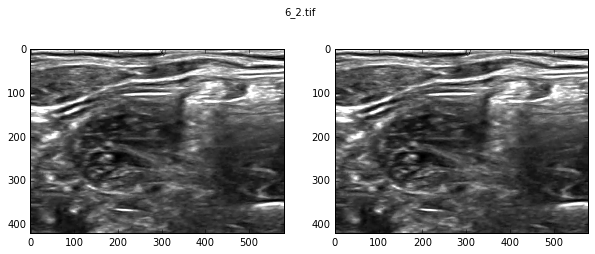

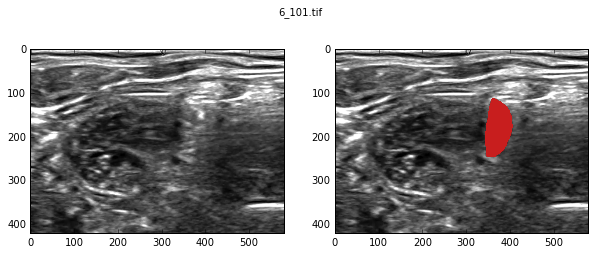

In [82]:
i, j = incoherent_ij[np.random.randint(incoherent_ij.shape[0])]

print utils.dice_coefficient(masks[i], masks[j])
print "D : ", D[i, j]
show(i)
show(j)

# Doing it on all images and creating a new "train_cleaned" dataset

In [83]:
import skimage
import skimage.io

In [84]:
OUTDIR = '../data/data_clean'
if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
utils.mkdir_p(OUTDIR)

def filter_images_for_patient(pid):
    imgs, masks, fnames = load_patient(pid)
    hists = np.array(map(compute_img_hist, imgs))
    D = spdist.squareform(spdist.pdist(hists, metric='cosine'))
    
    # Used 0.005 to train at 0.67
    close_pairs = D + np.eye(D.shape[0]) < 0.008
    
    close_ij = np.transpose(np.nonzero(close_pairs))
    
    incoherent_ij = [(i, j) for i, j in close_ij if utils.dice_coefficient(masks[i], masks[j]) < 0.2]
    incoherent_ij = np.array(incoherent_ij)
    
    #i, j = incoherent_ij[np.random.randint(incoherent_ij.shape[0])]
    
    valids = np.ones(len(imgs), dtype=np.bool)
    for i, j in incoherent_ij:
        if np.sum(masks[i]) == 0:
            valids[i] = False
        if np.sum(masks[j]) == 0:
            valids[i] = False

    for i in np.flatnonzero(valids):
        imgname = os.path.splitext(fnames[i])[0] + ".png"
        mask_fname = os.path.splitext(imgname)[0] + "_mask.png"
        img = skimage.img_as_ubyte(imgs[i])
        cv2.imwrite(os.path.join(OUTDIR, imgname), img)
        mask = skimage.img_as_ubyte(masks[i])
        cv2.imwrite(os.path.join(OUTDIR, mask_fname), mask)
    print 'Discarded ', np.count_nonzero(~valids), " images for patient %d" % pid

for pid in range(1, 48):
    filter_images_for_patient(pid)

Discarded  67  images for patient 1
Discarded  8  images for patient 2
Discarded  16  images for patient 3
Discarded  30  images for patient 4
Discarded  50  images for patient 5
Discarded  37  images for patient 6
Discarded  52  images for patient 7
Discarded  41  images for patient 8
Discarded  19  images for patient 9
Discarded  52  images for patient 10
Discarded  40  images for patient 11
Discarded  28  images for patient 12
Discarded  36  images for patient 13
Discarded  57  images for patient 14
Discarded  36  images for patient 15
Discarded  19  images for patient 16
Discarded  31  images for patient 17
Discarded  31  images for patient 18
Discarded  41  images for patient 19
Discarded  18  images for patient 20
Discarded  54  images for patient 21
Discarded  34  images for patient 22
Discarded  36  images for patient 23
Discarded  13  images for patient 24
Discarded  36  images for patient 25
Discarded  51  images for patient 26
Discarded  26  images for patient 27
Discarded  